# Find the Cut Value

In [1]:
import os, sys, pprint
import math
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import joblib

In [2]:
Local_Philipp = True

In [3]:
# Define branches that we need for our analysis
Masses = ['B0_M', 'B0_ErrM', 'B0_SigM', 'B0_K_S0_M', 'B0_K_S0_ErrM', 'B0_K_S0_SigM', 'B0_etap_M', 'B0_etap_ErrM', 
          'B0_etap_SigM', 'B0_etap_eta_M', 'B0_etap_eta_ErrM', 'B0_etap_eta_SigM']
Kinetics_CMS = ['B0_Pcms', 'B0_etap_Pcms', 'B0_etap_eta_Pcms', 'B0_etap_eta_gamma0_Pcms', 'B0_etap_eta_gamma1_Pcms',
                'B0_etap_pi0_Pcms', 'B0_etap_pi1_Pcms', 'B0_K_S0_Pcms']
Other_Kinetics = ['B0_deltae', 'B0_mbc']
DecayAngles = ['B0_decayAngle__bo0__bc', 'B0_decayAngle__bo1__bc', 'B0_etap_decayAngle__bo0__bc',
               'B0_etap_decayAngle__bo1__bc', 'B0_etap_decayAngle__bo2__bc']
Positions = ['B0_X', 'B0_ErrX', 'B0_Y', 'B0_ErrY', 'B0_Z', 'B0_ErrZ', 'B0_Rho',  
             'B0_etap_X', 'B0_etap_ErrX', 'B0_etap_Y', 'B0_etap_ErrY', 
             'B0_etap_Z', 'B0_etap_ErrZ', 'B0_etap_Rho',
             'B0_etap_eta_X', 'B0_etap_eta_ErrX', 'B0_etap_eta_Y',
             'B0_etap_eta_ErrY', 'B0_etap_eta_Z', 'B0_etap_eta_ErrZ', 'B0_etap_eta_Rho',
             'B0_etap_pi0_X', 'B0_etap_pi0_ErrX', 'B0_etap_pi0_Y', 'B0_etap_pi0_ErrY', 
             'B0_etap_pi0_Z', 'B0_etap_pi0_ErrZ', 'B0_etap_pi0_Rho', 
             'B0_etap_pi1_X', 'B0_etap_pi1_ErrX', 'B0_etap_pi1_Y', 'B0_etap_pi1_ErrY', 
             'B0_etap_pi1_Z', 'B0_etap_pi1_ErrZ', 'B0_etap_pi1_Rho', 
             'B0_K_S0_X', 'B0_K_S0_ErrX', 'B0_K_S0_Y', 'B0_K_S0_ErrY', 'B0_K_S0_Z',
             'B0_K_S0_ErrZ', 'B0_K_S0_Rho', 
             'B0_cosAngleBetweenMomentumAndVertexVector', 'B0_distance', 'B0_significanceOfDistance',
             'B0_dr', 'B0_etap_pi0_dr', 'B0_etap_pi1_dr', 'B0_K_S0_dr']
Vertex_Training = ['B0_VtxPvalue', 'B0_etap_VtxPvalue', 'B0_etap_eta_VtxPvalue', 'B0_etap_pi0_VtxPvalue',
                   'B0_etap_pi1_VtxPvalue', 'B0_K_S0_VtxPvalue', ]
Continuum_Suppression_Training = ['B0_TrCSMVA']

Training = Kinetics_CMS + Masses + Other_Kinetics + Continuum_Suppression_Training + Positions + DecayAngles + Vertex_Training
Important = Training + ['B0_isSignal', 'evt_no']

In [4]:
from root_pandas import read_root

if Local_Philipp : 
    path = '/home/philipp/Desktop/Project/DATA/'
    SFiles = glob.glob(os.path.join(path, 'Signal/*.root'))
    CFiles = glob.glob(os.path.join(path, 'Continuous/*.root'))
    PFiles = glob.glob(os.path.join(path, 'Peaking/*.root'))
    
Signal = pd.concat((read_root(f, 'B0', columns=Important) for f in SFiles))
Signal = Signal[Signal['B0_isSignal']==1].reset_index(drop=True)
Continuum_bkg = pd.concat((read_root(f, 'B0', columns=Important) for f in CFiles))
Peaking_bkg = pd.concat((read_root(f, 'B0', columns=Important) for f in PFiles))

#Signal: In case of more than 1 candidate per event select the first one occuring
Mask_duplicated = Signal.duplicated(subset='evt_no', keep='first')
Mask_duplicated=np.logical_not(Mask_duplicated)
Signal=Signal[Mask_duplicated]
Signal.reset_index(drop=True, inplace=True)

print("Signal : ",Signal.shape)
print(Signal['evt_no'].nunique())

Signal=Signal[Training]
Continuum_bkg=Continuum_bkg[Training]
Peaking_bkg=Peaking_bkg[Training]

Welcome to JupyROOT 6.16/00


/home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.16.4 is currently installed but you installed root_numpy against numpy 1.9.3. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


Signal :  (218596, 85)
218596


In [5]:
!ls Models/LateNight/

Best_Model.h5  Scaler.pkl


In [6]:
!ls ../DATA/

B0_etapr-eta-gg2pi_KS-pi+pi-_output_ccbar_0.root
B0_etapr-eta-gg2pi_KS-pi+pi-_output_charged_17.root
B0_etapr-eta-gg2pi_KS-pi+pi-_output_DC_0.root
B0_etapr-eta-gg2pi_KS-pi+pi-_output_DC_1.root
B0_etapr-eta-gg2pi_KS-pi+pi-_output_DC_2.root
B0_etapr-eta-gg2pi_KS-pi+pi-_output_DC_3.root
B0_etapr-eta-gg2pi_KS-pi+pi-_output_DC_4.root
B0_etapr-eta-gg2pi_KS-pi+pi-_output_DC_5.root
B0_etapr-eta-gg2pi_KS-pi+pi-_output_DC_6.root
B0_etapr-eta-gg2pi_KS-pi+pi-_output_DC_7.root
B0_etapr-eta-gg2pi_KS-pi+pi-_output_DC_8.root
B0_etapr-eta-gg2pi_KS-pi+pi-_output_DC_9.root
B0_etapr-eta-gg2pi_KS-pi+pi-_output_ddbar_0.root
B0_etapr-eta-gg2pi_KS-pi+pi-_output_mixed_0.root
B0_etapr-eta-gg2pi_KS-pi+pi-_output_sgnMC9_BGx1_0.root
B0_etapr-eta-gg2pi_KS-pi+pi-_output_ssbar_0.root
B0_etapr-eta-gg2pi_KS-pi+pi-_output_tau_0.root
B0_etapr-eta-gg2pi_KS-pi+pi-_output_uubar_0.root
Belle2
Continuous
DC
Peaking
Signal
Test


In [7]:
from random import seed
from random import randint

n_seed=1234
seed(n_seed)

In [8]:
Signal['Type'] = 2
Continuum_bkg['Type'] = 1
Peaking_bkg['Type'] = 0

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

#SIGNAL: Train, Validation and test split (50%, 30%, 20%)
#Dataset divided into 50% of train data and 50% for validation and test
X = Signal.drop('Type',axis=1)
Y = Signal['Type']
#Y = to_categorical(Y, num_classes=3) # Binarize the labels
X_train_S, X_test_val_S, Y_train_S, Y_test_val_S = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
#validation and test set divided into 30% for validation and 20% for test
X = X_test_val_S
Y = Y_test_val_S
X_validation_S, X_test_S, Y_validation_S, Y_test_S = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_S)
del(Y_test_val_S)

#CONTINUUM BKG: Train, Validation and test split (50%, 30%, 20%)
#Dataset divided into 50% of train data and 50% for validation and test
X = Continuum_bkg.drop('Type',axis=1)
Y = Continuum_bkg['Type']
#Y = to_categorical(Y, num_classes=3) # Binarize the labels
X_train_C, X_test_val_C, Y_train_C, Y_test_val_C = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
#validation and test set divided into 30% for validation and 20% for test
X = X_test_val_C
Y = Y_test_val_C
X_validation_C, X_test_C, Y_validation_C, Y_test_C = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_C)
del(Y_test_val_C)

#PEAKING BKG: Train, Validation and test split (50%, 30%, 20%)
#Dataset divided into 50% of train data and 50% for validation and test
X = Peaking_bkg.drop('Type',axis=1)
Y = Peaking_bkg['Type']
#Y = to_categorical(Y, num_classes=3) # Binarize the labels
X_train_P, X_test_val_P, Y_train_P, Y_test_val_P = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
#validation and test set divided into 30% for validation and 20% for test
X = X_test_val_P
Y = Y_test_val_P
X_validation_P, X_test_P, Y_validation_P, Y_test_P = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_P)
del(Y_test_val_P)

# del(Signal)
# del(Peaking_bkg)
# del(Continuum_bkg)

Using TensorFlow backend.


In [9]:
#Define Training, Validation and Test datasets
X_Train=np.concatenate((X_train_S, X_train_C, X_train_P), axis=0)
X_Validation=np.concatenate((X_validation_S, X_validation_C, X_validation_P), axis=0)
X_Test=np.concatenate((X_test_S, X_test_C, X_test_P), axis=0)

Y_Train=np.concatenate((Y_train_S, Y_train_C, Y_train_P), axis=0)
Y_Validation=np.concatenate((Y_validation_S, Y_validation_C, Y_validation_P), axis=0)
Y_Test=np.concatenate((Y_test_S, Y_test_C, Y_test_P), axis=0)

Ỳ_Test_not_encoded=Y_Test #needed for cut value analysis

Y_Train=to_categorical(Y_Train, num_classes=3) # Binarize the labels
Y_Validation=to_categorical(Y_Validation, num_classes=3) # Binarize the labels
Y_Test=to_categorical(Y_Test, num_classes=3) # Binarize the labels

print(X_Train.shape)
print(X_Validation.shape)
print(X_Test.shape)

print("X Train shape : ", X_Train.shape)
print("X Validation shape : ",X_Validation.shape)
print("X Test shape : ",X_Test.shape)
n_classes = Y_Train.shape[1]


#shuffle the dataset
permutation = np.random.permutation(X_Train.shape[0])
X_Train = X_Train[permutation]
Y_Train = Y_Train[permutation]

permutation = np.random.permutation(X_Validation.shape[0])
X_Validation = X_Validation[permutation]
Y_Validation = Y_Validation[permutation]

permutation = np.random.permutation(X_Test.shape[0])
X_Test = X_Test[permutation]
Y_Test = Y_Test[permutation]

(226320, 83)
(135791, 83)
(90529, 83)
X Train shape :  (226320, 83)
X Validation shape :  (135791, 83)
X Test shape :  (90529, 83)


In [10]:
from keras.models import load_model
from sklearn.preprocessing import StandardScaler

Loaded_Model = load_model('Models/LateNight/Best_Model.h5')
ss = joblib.load('Models/LateNight/Scaler.pkl')
ss.get_params()

W0722 09:21:31.975126 139901660645184 deprecation_wrapper.py:119] From /home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0722 09:21:32.003965 139901660645184 deprecation_wrapper.py:119] From /home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0722 09:21:32.004927 139901660645184 deprecation_wrapper.py:119] From /home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0722 09:21:32.016374 139901660645184 deprecation.py:506] From /home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropou

{'copy': True, 'with_mean': True, 'with_std': True}

2019-07-22 09:21:32.090579: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2019-07-22 09:21:32.130300: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2400000000 Hz
2019-07-22 09:21:32.131001: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55debca02fa0 executing computations on platform Host. Devices:
2019-07-22 09:21:32.131065: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
OMP: Info #212: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #210: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-3
OMP: Info #156: KMP_AFFINITY: 4 available OS procs
OMP: Info #1

In [11]:
X_Train = ss.fit_transform(X_Train)
X_Test = ss.transform(X_Test)
X_Validation = ss.transform(X_Validation)

In [12]:
pcTrain = X_Train
pcTest = X_Test
pcValidation = X_Validation

In [13]:
Loaded_Model.evaluate(pcTrain, Y_Train)

226320/226320 [==============================] - 3s 12us/step


[0.052207134628092976, 0.9847605160834217]

OMP: Info #250: KMP_AFFINITY: pid 15133 tid 15208 thread 1 bound to OS proc set 1
OMP: Info #250: KMP_AFFINITY: pid 15133 tid 15213 thread 2 bound to OS proc set 2
OMP: Info #250: KMP_AFFINITY: pid 15133 tid 15214 thread 3 bound to OS proc set 3
OMP: Info #250: KMP_AFFINITY: pid 15133 tid 15215 thread 4 bound to OS proc set 0
OMP: Info #250: KMP_AFFINITY: pid 15133 tid 15209 thread 5 bound to OS proc set 1
OMP: Info #250: KMP_AFFINITY: pid 15133 tid 15216 thread 6 bound to OS proc set 2
OMP: Info #250: KMP_AFFINITY: pid 15133 tid 15217 thread 7 bound to OS proc set 3
OMP: Info #250: KMP_AFFINITY: pid 15133 tid 15218 thread 8 bound to OS proc set 0


In [14]:
Test_prob = Loaded_Model.predict(pcTest)
Test_prob

array([[1.6822576e-03, 9.9831772e-01, 4.0527541e-09],
       [1.0750942e-03, 1.1136502e-04, 9.9881351e-01],
       [1.4636972e-03, 9.9607038e-01, 2.4658560e-03],
       ...,
       [8.0536408e-03, 9.9194628e-01, 8.5730626e-08],
       [2.1312661e-03, 9.9777812e-01, 9.0640504e-05],
       [1.1660993e-03, 4.2315136e-05, 9.9879164e-01]], dtype=float32)

In [15]:
Test_prob = Loaded_Model.predict(pcTest)
np.argmax(Test_prob, axis=1)

min_cut = 0.1
max_cut = 0.99
n_steps = 100
step_size = (max_cut-min_cut)/n_steps

cut_values = []
metriks1 = []
metriks2 = []
metriks3 = []
metriks4 = []
N_Ss = []
N_Bs = []

for i in range(0, n_steps) : 
    cut_value = min_cut + i*step_size
    cut_values.append(cut_value)
    N_S = 0
    N_B = 0
    for j in range(len(Test_prob)) : 
        if Test_prob[j][2] > cut_value :           #we classify it as signal
            if Y_Test[j][2] == 1 : N_S += 1        #it actually is signal
            elif Y_Test[j][2] == 0 : N_B +=1       #it isn't signal
            else : print("Unexpected!")            #This should not happen
    N_Ss.append(N_S)
    N_Bs.append(N_B)
    metrik1 = N_S/(math.sqrt(N_B+N_S))
    metrik2 = N_S/math.sqrt(N_B)
    metrik3 = N_S/N_B
    metrik4 = math.sqrt(N_S)/(N_B)
    metriks1.append(metrik1)
    metriks2.append(metrik2)
    metriks3.append(metrik3)    
    metriks4.append(metrik4)

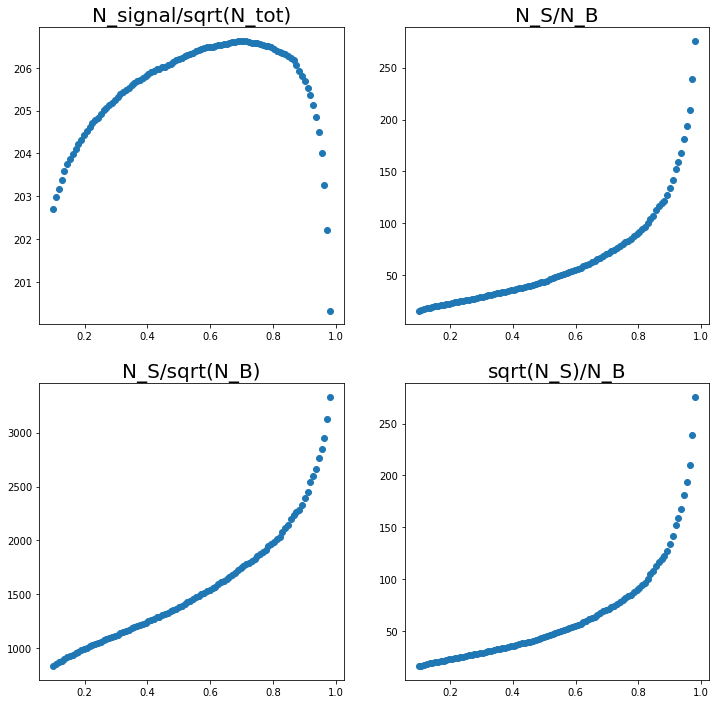

In [16]:
fig, ax = plt.subplots(2,2,figsize = (12,12))
ax[0][0].plot(cut_values, metriks1, 'o')
ax[0][0].set_title("N_signal/sqrt(N_tot)",fontsize=20)
#plt.xlabel("Cut value on signal probability",fontsize=20)
ax[1][0].plot(cut_values, metriks2, 'o')
ax[1][0].set_title("N_S/sqrt(N_B)", fontsize=20)
ax[0][1].plot(cut_values, metriks3, 'o')
ax[0][1].set_title("N_S/N_B", fontsize=20)
ax[1][1].plot(cut_values, metriks3, 'o')
ax[1][1].set_title("sqrt(N_S)/N_B", fontsize=20)
plt.show()

In [17]:
cut_values[np.argmax(metriks1)]

0.6962999999999999

In [18]:
Test_prob = Loaded_Model.predict(pcTest)
Y_Test_pred = np.argmax(Test_prob, axis=1)

n_steps = 100
cut_value = 0
to_maximize=[]
to_maximize_bis=[]
cut_values=[]

Test_df = pd.DataFrame({'Signal probability' : Test_prob[:,2],
                        'Y_true' : Ỳ_Test_not_encoded,
                        'Y_pred' : Y_Test_pred})


for i in range (0, n_steps):
    cut_value=i/n_steps 
    #cut_value = 0.98+(0.2*i)/n_steps #n_steps=1000 between 0.98 and 1
    Test_df_sel = pd.DataFrame()
    Test_df_sel = Test_df[Test_df['Signal probability']>cut_value] 
    N_tot=Test_df_sel.shape[0]
    if N_tot==0:
        print("******* ERROR!! N_tot is 0 *******")
        print(i)
        break
    #print(N_tot)
    N_true_signal = Test_df_sel[Test_df_sel['Y_true']==2].shape[0]
    #print(N_true_signal)
    N_false_signal = Test_df_sel[Test_df_sel['Y_true']!=2].shape[0]
    
    if(N_tot != (N_true_signal+N_false_signal)):
        print("****** ERROR!!! *********")
        break
    else:
        to_maximize.append(N_true_signal/math.sqrt(N_tot))
        #to_maximize_bis.append(N_true_signal/N_false_signal)
        cut_values.append(cut_value)
    
    
#print(to_maximize)
#print(cut_values)
#print(len(cut_values))  

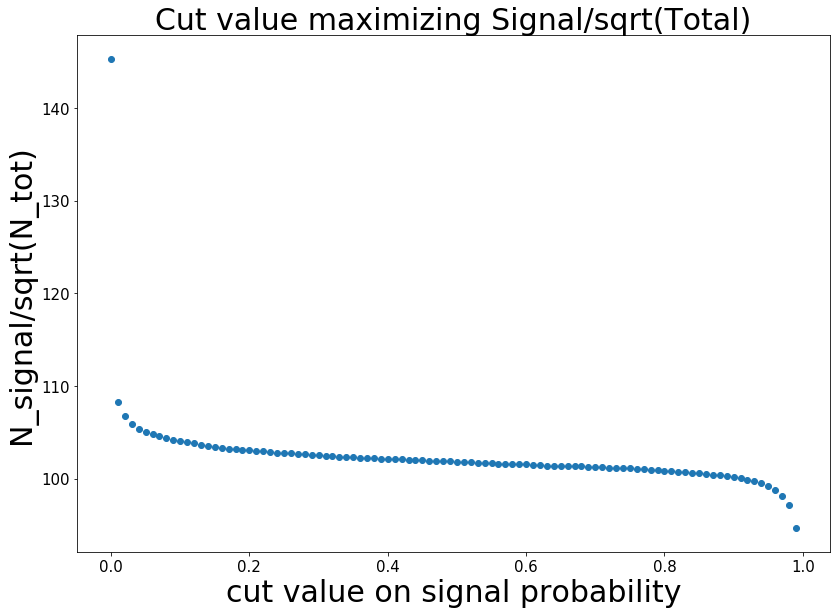

ValueError: x and y must have same first dimension, but have shapes (100,) and (0,)

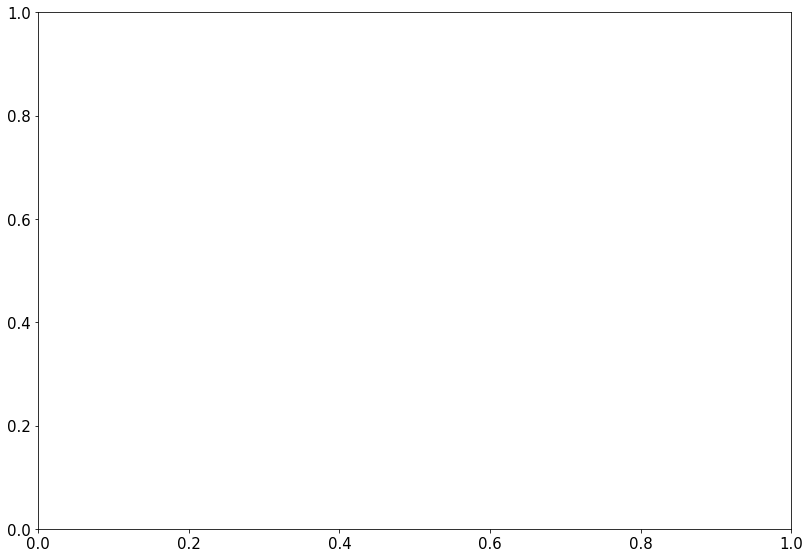

In [19]:
fig=plt.figure()
fig.set_size_inches(13.5, 9.5)
plt.tick_params(labelsize=15)
plt.plot(cut_values,to_maximize, 'o')
plt.title("Cut value maximizing Signal/sqrt(Total)",fontsize=30)
plt.xlabel("cut value on signal probability",fontsize=30)
plt.ylabel("N_signal/sqrt(N_tot)",fontsize=30)
plt.show()


fig=plt.figure()
fig.set_size_inches(13.5, 9.5)
plt.tick_params(labelsize=15)
plt.plot(cut_values,to_maximize_bis, 'o')
plt.title("Cut value maximizing Signal/sqrt(Background)",fontsize=30)
plt.xlabel("cut value on signal probability",fontsize=30)
plt.ylabel("N_signal/sqrt(N_background)",fontsize=30)
plt.show()  